## Language Level Classification with Feature Agglomeration

----

Project: Language Level Analysis and Classification <br>
Seminar *Educational Assessment for Language Technology* <br>
WS 2015/16, Magdalena Wolska


Julia Suter, January 2018


----
Language_Level_Classification_Feature_Agglomeration.ipynb

- train, test and evaluate language level classifier with feature agglomeration on different settings
- identify sparse / less relevant features
- feature clustering
- parameter screening (including cluster size)
- visualize feature clusters, feature relevance, and performance on differnet cluster sizes (if enabled)


### Import Statements

In [1]:
# Import Statements
import os
import sklearn
from sklearn import svm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import cluster
import sklearn

from warnings import simplefilter
simplefilter('ignore', FutureWarning)

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

### Feature Cluster Plotting

In [2]:
### Plot for showing feature clusters

def line_plot(clusters, names, colors):
    """Plot feature clusters.
    
    Args:       clusters (np.array)
                names (np.array)
                colors (list)
    """

    # Init
    fig = plt.figure(figsize=(18, 0.5))

    # Plot lines of appropriate length
    # Note 1: The "overhangs" may need manual adjustment to look nice.
    cluster_sizes = np.bincount(clusters)
    names_rdy = names.tolist()
        
    pos = 0.0
    for clust_size, color in zip(cluster_sizes, colors):
        plt.plot([pos-0.9, pos+clust_size-1+0.1], [0, 0], lw=7, c=color)
        pos += clust_size+1
        names_rdy.insert(int(pos-1),"")

            
    # Get axis
    ax = fig.gca()

    # Remove all the frame stuff
    ax.set_frame_on(False)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_visible(False)
    
    # Set the labels
    ax.set_xticks(range(len(names_rdy)))
    ax.xaxis.set_ticklabels(names_rdy, rotation=55, ha="right", fontsize=11)
    
    ax.set_xlim((-0.9, pos+clust_size-1+0.1))

    # Done
    plt.show()

## Load features and names

In [3]:
version = 'default'     # or: default_nopara, non_linear_rbf
baseline = False
version = 'baseline' if baseline else version

# use literary texts from Gutenberg instead of Language Levels
literature_version = False

# get data dir
data_dir = '../3_Text_features/Features/'
#data_dir = '../3_Text_features/Features_truncated_beginning/'
#data_dir = '../3_Text_features/Features_truncated_middle/'
# = '../3_Text_features/Features_5sents_chunks/'

if literature_version:
    data_dir = '../3_Text_features/Literature_Features/'
    #data_dir = '../3_Text_features/Literature_Features_short/'

find_cluster_n = False
para_screening = False

# constants
RANDOM_STATE = 41
TRAIN_SIZE = 0.9
NUMBER_OF_FEATURES = None
MIN_N_WORDS = 0
MIN_N_SENTS = 3
N_REL_FEATURES = 15

# use different training size for literature set
if literature_version:
    TRAIN_SIZE = 0.8
    
# select features to agglomerate by sparsity or relevance
sparsity_selected = False  # not used
sparsity = False
rel_features = True

# activate feature agglomeration and select nr of clusters
feat_agglo = True
n_clusters = 5

# select subset of features
only_non_agglo_f = False
only_agglo_f = False

print('Settings\n-----------')
print('Version: {}'.format(version))
print('Baseline: {}'.format(baseline))
print('Data from: {}'.format(data_dir[18:]))

Settings
-----------
Version: default
Baseline: False
Data from: /Features/


In [4]:
# for assigning labels
label_dict = {0:'A1',1:'B1',2:'B2',3:'A2'}

# collect data
all_feature_arrays = []
solutions = []
all_sents_n = []

total_files_original = 0

# for each dir in [A1,A2,B1,B2]
for i,directory in enumerate(os.listdir(data_dir)):

    # get number of files
    all_files = os.listdir(data_dir+directory) 
    total_files_original += len(all_files)

    # get number of features for feature array
    if baseline:
        NUMBER_OF_FEATURES = 2
    else:
        sample_file = all_files[0]
        df = pd.read_csv(data_dir+directory+'/'+sample_file)
        array = np.array(df)        
        NUMBER_OF_FEATURES = array.shape[0]-4
        
    # set feature array
    feature_array = np.zeros((len(all_files), NUMBER_OF_FEATURES))

    # for each file in subfolder
    for j, file in enumerate(all_files):

        # read data in pandas df (just for fun)
        df = pd.read_csv(data_dir+directory+'/'+file)

        # transform into array
        array = np.array(df)

        # get values and names
        features = array[:,1]         
        feature_names = array[:,0]

        # get number of words and sents
        n_words = features[2]
        n_sents = features[3]
        
        # FILTERING if needed
        if n_words < MIN_N_WORDS:
            continue
        if n_sents < MIN_N_SENTS:
            continue

        # get all features (except words per sent, LIX, opposite if baseline)
        # n_sents, n_words is never used
        features = features[:2] if baseline else features[4:]
        feature_names = features_names[:2] if baseline else feature_names[4:]

        # IF ONLY RELEVANT FEATURES
        #features = features[:2] if baseline else features[4+27:]
        #features = np.delete(features,-4)
        #feature_names = np.delete(feature_names,-4)

        # save features in array
        feature_array[j] = features
        
        
    # if FILTERING remove empty rows
    feature_array = feature_array[~(feature_array==0).all(1)]

    # add correct label to solution dict (x times; x = number of samples)
    solutions.extend([directory]*feature_array.shape[0]) 
    
    # append feature array 
    all_feature_arrays.append(feature_array)

    
# concatenate feature arrays
feature_array = np.concatenate(all_feature_arrays)
# transform solution array
solution_array = np.array(solutions)            

# print for fun
print('# samples: {}'.format(feature_array.shape[0]))
print('# features: {}'.format(feature_array.shape[1]))

# how many were filtered out
print('# filtered out docs: {}'.format(total_files_original-feature_array.shape[0]))

# samples: 264
# features: 80
# filtered out docs: 0


## Feature Agglomeration

In [5]:
def feature_agglomeration(n_clusters, feature_array_s, feature_array_n, s_names, n_names, 
                          only_agglo_f=False, only_non_agglo_f=False):
    """Feature agglomeration: reduce feature space (feature_array_s) to a specific number of features
    
    Args:       n_clusters (int)
                feature_array_s (np.array)   # sparse/non-relevant
                feature_array_n (np.array)   # non-sparse/relevant
                s_names (np.array)
                n_names (np.array)
                only_agglo_f (Boolean)
                only_non_agglo_f (Boolean)
                 
    Returns:    feature_array_final (np.array)
                f_names (np.array)
    """
        
    
    # Scale features
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    feature_array_s = scaler.fit_transform(feature_array_s)
    
    # if only relevant (or non-sparse) features are used
    if only_non_agglo_f:
        feature_array_n = scaler.fit_transform(feature_array_n)

    # define cluster
    cluster = sklearn.cluster.FeatureAgglomeration(n_clusters=n_clusters, affinity='l2',
                                               connectivity=None, compute_full_tree='auto', 
                                               linkage='average',
                                               pooling_func=np.sum)
    
    # if only relevant (or non-sparse) features are feature agglomerated
    if only_non_agglo_f:
        
        
        # fit data
        cluster.fit(feature_array_n)
        X_reduced = cluster.transform(feature_array_n)

        # examine labels
        labels = cluster.labels_
        argsort_labels = np.argsort(labels)
        
        # assign agglomerated features to feature array
        feature_array_n = X_reduced
       
    # if sparse/non-relevant features are feature agglomerated
    else:        
        
        np.save('sample_feature_array',feature_array_s)
        print(feature_array_s.shape)
        
        print()
        # fit data
        cluster.fit(feature_array_s)                
        X_reduced = cluster.transform(feature_array_s)

        # examine labels
        labels = cluster.labels_
        argsort_labels = np.argsort(labels)
        
        # plot feature clusters
        line_plot(labels[argsort_labels], s_names[argsort_labels], ["b","g","r","c","m"])
        
        # assign agglomerated features to feature array
        feature_array_s = X_reduced
    
    print('Clustered features: {}'.format(X_reduced.shape[1]))

    #### define scaler
    scaler = sklearn.preprocessing.StandardScaler()

    # scale features again
    feature_array_s = scaler.fit_transform(feature_array_s)
    feature_array_n = scaler.fit_transform(feature_array_n)

    # both rel/non-sparse or non-rel/parse are used, merge the two feature sets
    if not only_agglo_f and not only_non_agglo_f:
        
        # merge sparse features and non-sparse features
        feature_array_final = np.concatenate((feature_array_s,feature_array_n), axis=1)
        f_names = np.concatenate((s_names, n_names))
    
    # if only sparse/non-rel features are feature agglomerated
    if only_agglo_f:
        
        # put together final feature array
        f_names = s_names
        feature_array_final = feature_array_s
               
    # if only relevant/non-sparse features are feature agglomerated
    if only_non_agglo_f:
       
        # put together final feature array
        f_names = n_names
        feature_array_final = feature_array_n

        
    print('Final number of features: {}'.format(feature_array_final.shape[1]))
          
    return feature_array_final, f_names

In [6]:
def train_classifier(feature_array_final, solution_array, linearSVM=True):
    
    """Train classifier when giving feature array and solution array;
    linear or C-SVC; works for both with and without feature agglomeration)
    
    Args:       feature_array_final (np.array)
                solution_array (np.array)
                linearSVM (Boolean)
                 
    Returns:    classifier (sklearn.svm.classes.LinearSVC/SVC)
                accuracies (np.array)
    """
    
        
    # split data
    f_train, f_test, s_train, s_test = sklearn.model_selection.train_test_split(feature_array_final, 
                                                   solution_array,                                                                             
                                                   train_size=TRAIN_SIZE,
                                                   stratify=solution_array,
                                                   random_state=RANDOM_STATE)
    
    
    print('Training samples:', f_train.shape[0])
    print('Test samples:', f_test.shape[0])
    # get labels    
    labels = np.unique(s_train,return_counts=True)[0]
    
    ## train classifier
    classifier = svm.LinearSVC(random_state=RANDOM_STATE, tol=0.001, C=1.7)
    if linearSVM==False:
        classifier = svm.SVC(random_state=RANDOM_STATE) # non-linear
        
    # fit classifier
    classifier.fit(f_train, s_train)
    
    # cross validation classifier
    cv_classifier = svm.LinearSVC(random_state=RANDOM_STATE,tol=1.0, C=2.2)
    
    if linearSVM == False:    
        # non-linear
        cv_classifier = svm.SVC(random_state=RANDOM_STATE) 

    # cross validation
    cv_ = sklearn.model_selection.ShuffleSplit(n_splits = 50, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

    # get scores
    accuracies = sklearn.model_selection.cross_val_score(cv_classifier, 
                                                feature_array_final, solution_array, 
                                                cv=cv_, scoring='accuracy')   
    
    precision_m = sklearn.model_selection.cross_val_score(cv_classifier, feature_array_final, 
                                                        solution_array, cv=cv_, 
                                                        scoring='precision_weighted')

    recall_m = sklearn.model_selection.cross_val_score(cv_classifier, feature_array_final, 
                                                        solution_array, cv=cv_, 
                                                        scoring='recall_weighted')

    f1_m = sklearn.model_selection.cross_val_score(cv_classifier, feature_array_final, 
                                                        solution_array, cv=cv_, 
                                                        scoring='f1_weighted')


    # printing

    print('\n~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ ')
    print('\nAccuracies:')
    print('Mean:',np.mean(accuracies))
    print('STD: ',np.std(accuracies))

    print('\nWeighted precision')
    print('Mean:',np.mean(precision_m))
    print('STD: ',np.std(precision_m))

    print('\nWeighted recall:')
    print('Mean:',np.mean(recall_m))
    print('STD: ',np.std(recall_m))

    print('\nWeighted F1:')
    print('Mean:',np.mean(f1_m))
    print('STD: ',np.std(f1_m))
    
    return classifier, np.mean(accuracies), labels

In [7]:
def normal_processing(feature_array_s, feature_array_n, s_names, n_names, 
                          only_agglo_f=False, only_non_agglo_f=False):
    
    """Normal processing for version without feature agglomeration;
    combines feature array and scales featues
    
    Args:       feature_array_s (np.array)
                feature_array_n (np.array)
                s_names (np.array)
                n_names (np.array)
                only_agglo_f (Boolean)
                only_non_agglo_f (Boolean)
                 
    Returns:    classifier (sklearn.classifier)
                f_names (np.array)
    """
    
    # put together final feature array
    
    if not only_agglo_f and not only_non_agglo_f:
        # merge sparse features and non-sparse features
        feature_array_final = np.concatenate((feature_array_s,feature_array_n), axis=1)
        f_names = np.concatenate((s_names, n_names))
        
    if only_agglo_f:        
        f_names = s_names
        feature_array_final = feature_array_s
               
    if only_non_agglo_f:        
        f_names = n_names
        feature_array_final = feature_array_n
                
    #### Scale features
    scaler = sklearn.preprocessing.StandardScaler()
    feature_array_final = scaler.fit_transform(feature_array_final)
    
    print('Final number of features: {}'.format(feature_array_final.shape[1]))

    return feature_array_final, f_names


### Get sparse features

In [8]:
# Hand selected sparse features (not used here!)
selected_sparse_features_names = np.array(['pers pron count','refl pron count','modal count','split verbs count',
                        'gen mod count','prep with gen count', 'dat obj count','all gens count',
                        'gen+prep obj count','pqp count','past count', 'perfect count',
                        'all perfect counts','praet aux count','futur 1 count','futur 2 count','all futurs count',
                        'konj 1 count','konj 2 count','konj aux count','ind speech count','irrealis count',
                        'all konjs count','imperative count','passive count','passive w agens','comp count',
                        'sup count','comp+sup count','rel count','part pres count','part praet count',
                        'all part count',
                        'es count','brauchen count','lassen count','brauchen/lassen count','adversative','local',
                        "question words count",'question marks count',"prep obj count",
                        "subjunctions"])       

print('Hand selected sparse features: {}\n'.format(selected_sparse_features_names.shape[0]))
selected_sparse_features_indices = np.in1d(feature_names,selected_sparse_features_names)
selected_sparse_features_names = feature_names[selected_sparse_features_indices]
selected_sparse_features = feature_array[:, selected_sparse_features_indices]

Hand selected sparse features: 43



In [9]:
# features with zeros
f_zeros = (feature_array == 0).sum(0)

# get sparse features
sparse_features = (f_zeros >= feature_array.shape[0]*0.33)

# indices of sparse and non-sparse features
sparse_index = np.where(sparse_features)[0]
non_sparse_index = np.where(np.invert(sparse_features))[0]

# print number of sparse and non-sparse features; print sum
print('Sparse features\n------------------')
print('All features: {}'.format(len(feature_names[sparse_index])+len(feature_names[non_sparse_index])))
print('Sparse features: {}'.format(len(feature_names[sparse_index])))
print('Non-sparse features: {}'.format(len(feature_names[non_sparse_index])))

#print('\nNon-sparse features:\n {}'.format(feature_names[non_sparse_index]))

Sparse features
------------------
All features: 80
Sparse features: 43
Non-sparse features: 37


Original shape: (264, 80)
Less relevant features: 65
Relevant features: 15

(264, 65)



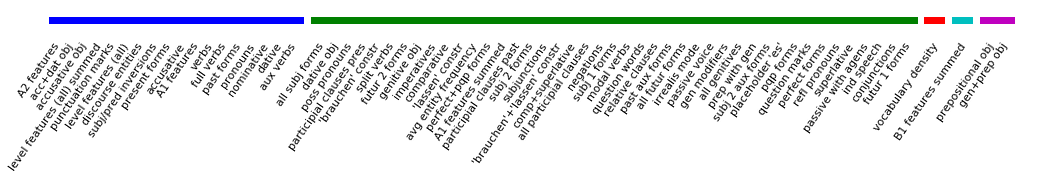

Clustered features: 5
Final number of features: 20
Training samples: 237
Test samples: 27

~~~~~ ~~~~~ ~~~~~ ~~~~~ ~~~~~ 

Accuracies:
Mean: 0.9466666666666665
STD:  0.04515481675297236

Weighted precision
Mean: 0.9535908762019875
STD:  0.04135493758801936

Weighted recall:
Mean: 0.9466666666666665
STD:  0.04515481675297236

Weighted F1:
Mean: 0.946350697317165
STD:  0.04544495649774911


In [10]:
# sorted indices for relevant features

if literature_version:
    sort_idx = np.load('./outputs_lit/sorted-idx.npy')
else:
    sort_idx = np.load('./outputs/sorted-idx.npy')
    
print('Original shape: {}'.format(feature_array.shape))

# if features are selected by sparsity
if sparsity and not rel_features:
    
    # sparse features and names
    feature_array_s = feature_array[:,sparse_index]
    s_names = feature_names[sparse_features]
    
    # non-sparse features and names
    feature_array_n = feature_array[:,non_sparse_index]    
    n_names = feature_names[non_sparse_index]
    
    print('Sparse features: {}'.format(feature_array_s.shape[1]))
    print('Non-sparse features: {}'.format(feature_array_n.shape[1]))
        
# if hand selected sparse feature list is used
if sparsity_selected:
 
    feature_array_s = feature_array[:,real_sparse_features_indices]
    s_names = feature_names[real_sparse_features_indices]
    
    feature_array_n = feature_array[:,np.invert(real_sparse_features_indices)]
    n_names = feature_names[np.invert(real_sparse_features_indices)]
    
    print('Sparse features: {}'.format(feature_array_s.shape[1]))
    print('Non-sparse features: {}'.format(feature_array_n.shape[1]))
    
# if relevant feature sortidx is used
if rel_features:
    
    # less-rel features and names
    feature_array_s = feature_array[:,sort_idx[N_REL_FEATURES:]]
    s_names = feature_names[sort_idx[N_REL_FEATURES:]]    
        
    # relevant features and names
    feature_array_n = feature_array[:,sort_idx[:N_REL_FEATURES]]   
    n_names = feature_names[sort_idx[:N_REL_FEATURES]]
    
    print('Less relevant features: {}'.format(feature_array_s.shape[1]))
    print('Relevant features: {}\n'.format(feature_array_n.shape[1]))
       

# if feature agglomeration is used
if feat_agglo:
    feature_array_final, f_names = feature_agglomeration(n_clusters, 
                                                         feature_array_s, 
                                                         feature_array_n, 
                                                         s_names, n_names, 
                                                         only_agglo_f=only_agglo_f,
                                                         only_non_agglo_f=only_non_agglo_f)
# without feature agglomeration
else:
    feature_array_final, f_names = normal_processing(feature_array_s, 
                                                     feature_array_n, 
                                                     s_names, n_names, 
                                                     only_agglo_f=only_agglo_f, 
                                                     only_non_agglo_f=only_non_agglo_f)

# train classifier
classifier,_, labels = train_classifier(feature_array_final, solution_array)

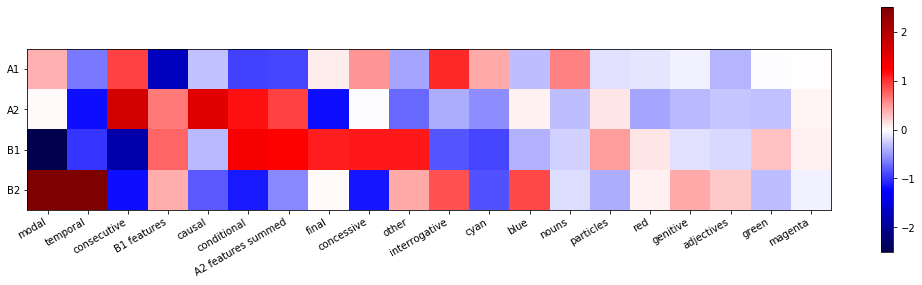

In [11]:
def plot_features_by_relevance(classifier, feature_names):
    """Plot the features sorted by relevance
    
    Args:     classifier (sklearn.svm.classes.LinearSVC)
              feature_names (np.array) 
    """
    
    # sorted indices (feature with highest coefficients first)
    sort_idx = np.argsort(-abs(classifier.coef_).max(axis=0))
    
    assert (len(feature_names)) == len(sort_idx) 
    
    # get sorted coefficients and feature names
    sorted_coef = classifier.coef_[:,sort_idx]
    sorted_fnames = feature_names[sort_idx]

    # plot feature coefficients
    x_fig = plt.figure(figsize=(18,5))
    plt.imshow(sorted_coef, interpolation='none', cmap='seismic',vmin=-2.5, vmax=2.5)
    plt.colorbar()
    plt.gca().set_yticks(range(len(labels)))
    plt.gca().set_yticklabels(labels)

    plt.gca().set_xticks(range(len(feature_names)))
    plt.gca().set_xticklabels(sorted_fnames)

    x_fig.autofmt_xdate()
    plt.show()
    

# get feature names for feat agglo (sparse or less rel f)
all_f_names = [np.array(['blue','green','red','cyan','magenta']),n_names] 
feature_names = np.concatenate(all_f_names)

# if only less relevant features are used
if only_agglo_f:
    
    if feat_agglo:        
        feature_names = np.array(['blue','green','red','cyan','magenta'])
    else:
        feature_names = s_names
        
# if only relevant features
if only_non_agglo_f:
        feature_names = f_names
        
# plot
plot_features_by_relevance(classifier, feature_names)

In [12]:
def find_best_cluster_n():
    """
    Plots the accuracy for different cluster sizes
    """
    all_accuracies = []
    for i in range(1,20):
        feature_array_final, f_names = feature_agglomeration(i,
                                                         feature_array_s, 
                                                         feature_array_n, 
                                                         s_names, n_names, 
                                                         only_agglo_f=only_agglo_f,
                                                         only_non_agglo_f=only_non_agglo_f)
        
        
        _, acc = train_classifier(feature_array_final, solution_array)
        all_accuracies.append(acc)

    plt.plot(range(1,20), all_accuracies)
    plt.show()
    
if find_cluster_n:
    find_best_cluster_n()


In [13]:
def linear_para_screening():
    """
    Parameter screening for linear support vector classification
    """

    linear_para_dict = {'C':[0.1,0.5,1.0,1.5,2.0,2.5],
                    'tol':[0.0001,0.001,0.01,0.1,1,0.00001]}
    
    cv_ = sklearn.model_selection.ShuffleSplit(n_splits = 50, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)
    cv_classifier = svm.LinearSVC()
    para_search  = sklearn.model_selection.GridSearchCV(cv_classifier, linear_para_dict, cv=cv_)
    para_search.fit(feature_array_final, solution_array)
    print(para_search.best_score_)
    print(para_search.best_params_)
    
if para_screening:
    linear_para_screening()